# SUPERNOVAE
Also in this case we have data of the absolute distance as a function of the redshift:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import emcee
import dynesty
from dynesty import plotting
from astroML.datasets import generate_mu_z
import sklearn.gaussian_process as gp
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from astropy.cosmology import LambdaCDM
from tqdm import tqdm
from corner import corner

Text(0, 0.5, '$\\mu$')

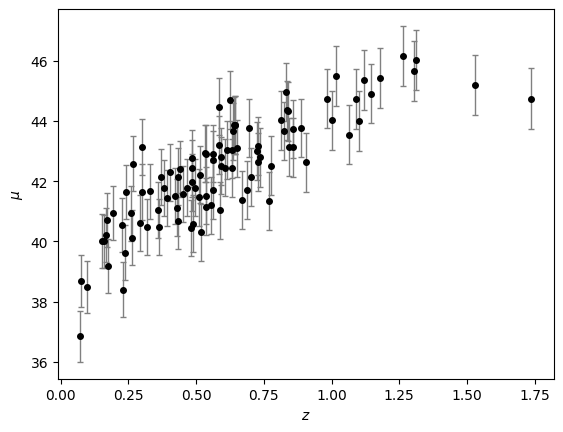

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)
plt.errorbar(z_sample, mu_sample, dmu, fmt='o', color='black', ecolor='gray', markersize=4, lw=1, capsize=2)
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu$")

## Gaussian Process Regression
We again want to fit the data in a data driven way, but instead of using a polynomial regression, we now use the Gaussian Process Regression, which is a non linear technique. We decided to use a Radial-basis kernel:
$$A\exp{\biggl(-\frac{(x_1 - x_2)^2}{2h^2}}\biggr).$$
To choose the values of the parameters we do a 5-fold cross-validation. Then we consider the best hyperparameters to be the ones that minimize the RMS on the cross-validation sample:

In [3]:
rng = np.random.default_rng(seed=130301)
indices = np.arange(len(z_sample))
rng.shuffle(indices)
K = 5

train_len = int(len(z_sample) - len(z_sample) / K)
val_len = int(len(z_sample) / K)
rms_tr = np.zeros(K)
rms_te = np.zeros(K)
rms_tr_model = np.zeros(0)
rms_te_model = np.zeros(0)
n_A = 150
n_h = 150
A = np.linspace(950, 1050, n_A)
h = np.linspace(0.1, 5.0, n_h)
for A_act in tqdm(range(n_A)):
    for h_act in range(n_h):
        for i in range(0, K):
            test_data = indices[val_len * i : val_len * (i+1)]
            train_data = indices[0:val_len * i]
            train_data = np.append(train_data, indices[val_len * (i+1) : len(z_sample)])
            reg = gp.GaussianProcessRegressor(kernel=A[A_act] * gp.kernels.RBF(h[h_act]), alpha = dmu[train_data]**2, optimizer=None)
            reg.fit(z_sample[train_data][:, np.newaxis], mu_sample[train_data])
            pred_train = reg.predict(z_sample[train_data][:, np.newaxis])
            pred_test = reg.predict(z_sample[test_data][:, np.newaxis])
            rms_tr[i] = np.sqrt(np.sum(((mu_sample[train_data] - pred_train) ** 2) / dmu[train_data] ** 2)/len(train_data))
            rms_te[i] = np.sqrt(np.sum(((mu_sample[test_data] - pred_test) ** 2) / dmu[test_data] ** 2)/len(test_data))
        rms_tr_model = np.append(rms_tr_model, np.mean(rms_tr))
        rms_te_model = np.append(rms_te_model, np.mean(rms_te))

print(rms_tr_model)
print(rms_te_model)

100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [02:30<00:00,  1.00s/it]

[0.78951144 0.81849667 0.84453506 ... 0.96587079 0.96611136 0.96635872]
[4.15024876 3.23622772 2.21012068 ... 0.98259748 0.98296251 0.98333576]


Here we have the values of the hyperparameters:

In [4]:
A_best, h_best = A[int(np.argmin(rms_te_model)/n_h)], h[np.argmin(rms_te_model) % n_A]
print("Best value of A: {:.3f}".format(A_best))
print("Best value of h: {:.3f}".format(h_best))

Best value of A: 956.711
Best value of h: 1.087


30.9**2 * RBF(length_scale=1.09)


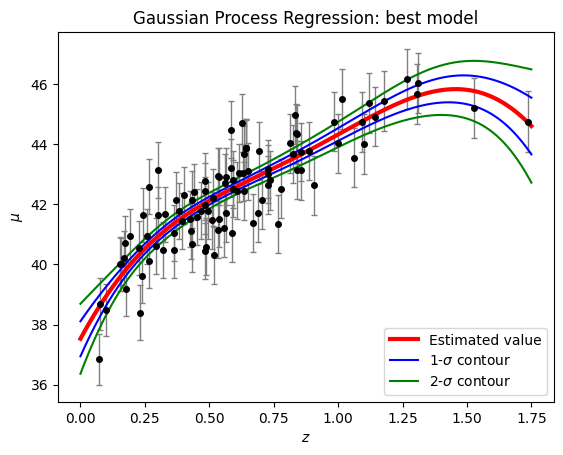

In [5]:
ker = A_best*gp.kernels.RBF(h_best)
reg_gp = gp.GaussianProcessRegressor(kernel=ker, alpha = dmu**2, optimizer=None)

reg_gp.fit(z_sample[:, np.newaxis], mu_sample)
xgrid = np.linspace(0, 1.75, 1000)
yfit, err_y_fit = reg_gp.predict(xgrid[:, np.newaxis], return_std=True)

print(reg_gp.kernel_)
plt.errorbar(z_sample, mu_sample, dmu, fmt='o', color='black', ecolor='gray', markersize=4, lw=1, capsize=2)
plt.plot(xgrid, yfit, color='red', lw=3, label="Estimated value")
plt.plot(xgrid, yfit-err_y_fit, color = 'blue', label=r"1-$\sigma$ contour")
plt.plot(xgrid, yfit+err_y_fit, color = 'blue')
plt.plot(xgrid, yfit-2*err_y_fit, color = 'green', label=r"2-$\sigma$ contour")
plt.plot(xgrid, yfit+2*err_y_fit, color = 'green')
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu$")
plt.title("Gaussian Process Regression: best model")
plt.legend()

We can see here how the uncertainty on the estimated value of $\mu (z)$ is much bigger at the ends of the dataset: this reflects the fact that in those regions we have less data, so the fit is more uncertain.

## Fit with the cosmological model
Now we introduce our physical knowledge of the problem. In fact, we know, if we consider the $\Lambda$CDM model, which is $\mu (z)$. In a flat universe:
$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+(1 - \Omega_m)}} \right), $$
which is a model that depends on the two parameters: the Hubble parameter $H_0$ and the fraction of matter content of the Universe $\Omega_m$.

This time we'll use a full Bayesian framework. We'll assume:
1) the likelihood is gaussian;
2) $\Omega_m \in [0, 1]$ (is a fraction);
3) $H_0 \in [50.0, 50.0]$ km/s/Mpc.

So we run an MCMC:

In [6]:
def gen_model(z, par):
    tmp = LambdaCDM(H0=par[0], Om0=par[1], Ode0=1.0-par[1])
    return tmp.distmod(z).value

model = gen_model

def loglikelihood(par):
    return -0.5*np.sum((mu_sample - model(z_sample, par))**2.0 / dmu**2.0 - 0.5*np.log(2*np.pi*(dmu**2.0)))

def priorH0(H_0):
    return st.uniform(50.0, 50.0).pdf(H_0)

def priorOm(O_m):
    return st.uniform(0, 1).pdf(O_m)

def log_posterior(par):
    log_prior = np.log(priorH0(par[0])) + np.log(priorOm(par[1]))
    if not np.isfinite(log_prior):
        return -np.inf
    else:
        return loglikelihood(par) + log_prior

In [7]:
n_walkers = 8
n_par = 2
init_par = np.full((n_walkers, n_par), [72.0, 0.30])
for i in range(n_walkers):
    for j in range(n_par):
        init_par[i, j] = init_par[i, j] * st.uniform(0.9, 0.2).rvs(1)

/tmp/ipykernel_113368/1285814490.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  init_par[i, j] = init_par[i, j] * st.uniform(0.9, 0.2).rvs(1)


In [8]:
n_step = 50000
sampler = emcee.EnsembleSampler(n_walkers, n_par, log_posterior, moves=emcee.moves.StretchMove(5.0))
_ = sampler.run_mcmc(init_par, n_step)

/tmp/ipykernel_113368/3267799544.py:17: RuntimeWarning: divide by zero encountered in log
  log_prior = np.log(priorH0(par[0])) + np.log(priorOm(par[1]))


#### Diagnostic information

In [9]:
print("Acceptance rates for every walker:")
print(sampler.acceptance_fraction)

Acceptance rates for every walker:
[0.40976 0.41294 0.40974 0.4075  0.40648 0.40442 0.40956 0.4084 ]


Text(0, 0.5, '$\\Omega_m$')

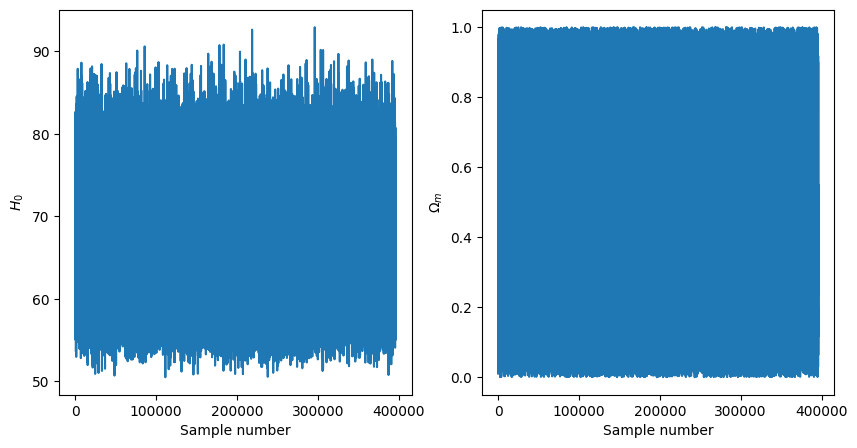

In [10]:
burn_in = 500
samples = sampler.chain[:, burn_in:, :]
samples = np.reshape(samples, (-1, n_par))

fig = plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(range(np.size(samples[:, 0])), samples[:, 0])
plt.xlabel("Sample number")
plt.ylabel(r"$H_0$")
plt.subplot(1,2,2)
plt.plot(range(np.size(samples[:, 1])), samples[:, 1])
plt.xlabel("Sample number")
plt.ylabel(r"$\Omega_m$")

The acceptance rate is between 20% and 50%, and the trace plots are good.
### Results of the MCMC

In [11]:
burn_in = 500
thin = int(np.max(sampler.get_autocorr_time()) + 1)
print("Maximum (rounded) autocorrelation lenght: {}".format(thin))
decorr_sample = sampler.get_chain(discard = burn_in, thin = thin)
decorr_sample = np.reshape(decorr_sample, (-1, 2))
print(len(decorr_sample))

Maximum (rounded) autocorrelation lenght: 29
13648


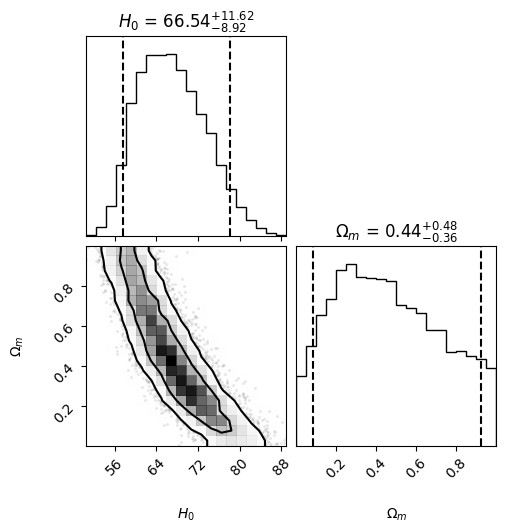

In [12]:
fig = corner(decorr_sample, labels = [r"$H_0$", r"$\Omega_m$"], levels = (0.68,0.95),\
                    quantiles = [0.05, 0.95], show_titles=True, title_quantiles=[0.05, 0.5, 0.95])

On the plots we can read the best estimate of the parameters given as the median and the 90% credible region. Both contain the accepted values.
### Only-Matter model
We now want to see if the data we have there is an evidence of dark energy. So we compare the model above with itself where $\Omega_m = 1$. To do this, we compute the evidences of the two models with nested sampling:
#### General model

In [13]:
def prior_transf(par):
    priors = np.zeros(n_par)
    priors[0] = 50.0 + 50.0*par[0]
    priors[1] = par[1]
    return priors

In [14]:
sampler_gen = dynesty.NestedSampler(loglikelihood, prior_transf, n_par, nlive = 1000)
sampler_gen.run_nested()
gen_result = sampler_gen.results

2546it [00:05, 434.62it/s, +1000 | bound: 0 | nc: 1 | ncall: 13357 | eff(%): 28.696 | loglstar:   -inf < -3.171 <    inf | logz: -5.441 +/-  0.019 | dlogz:  0.001 >  1.009]


#### Diagnostic plots

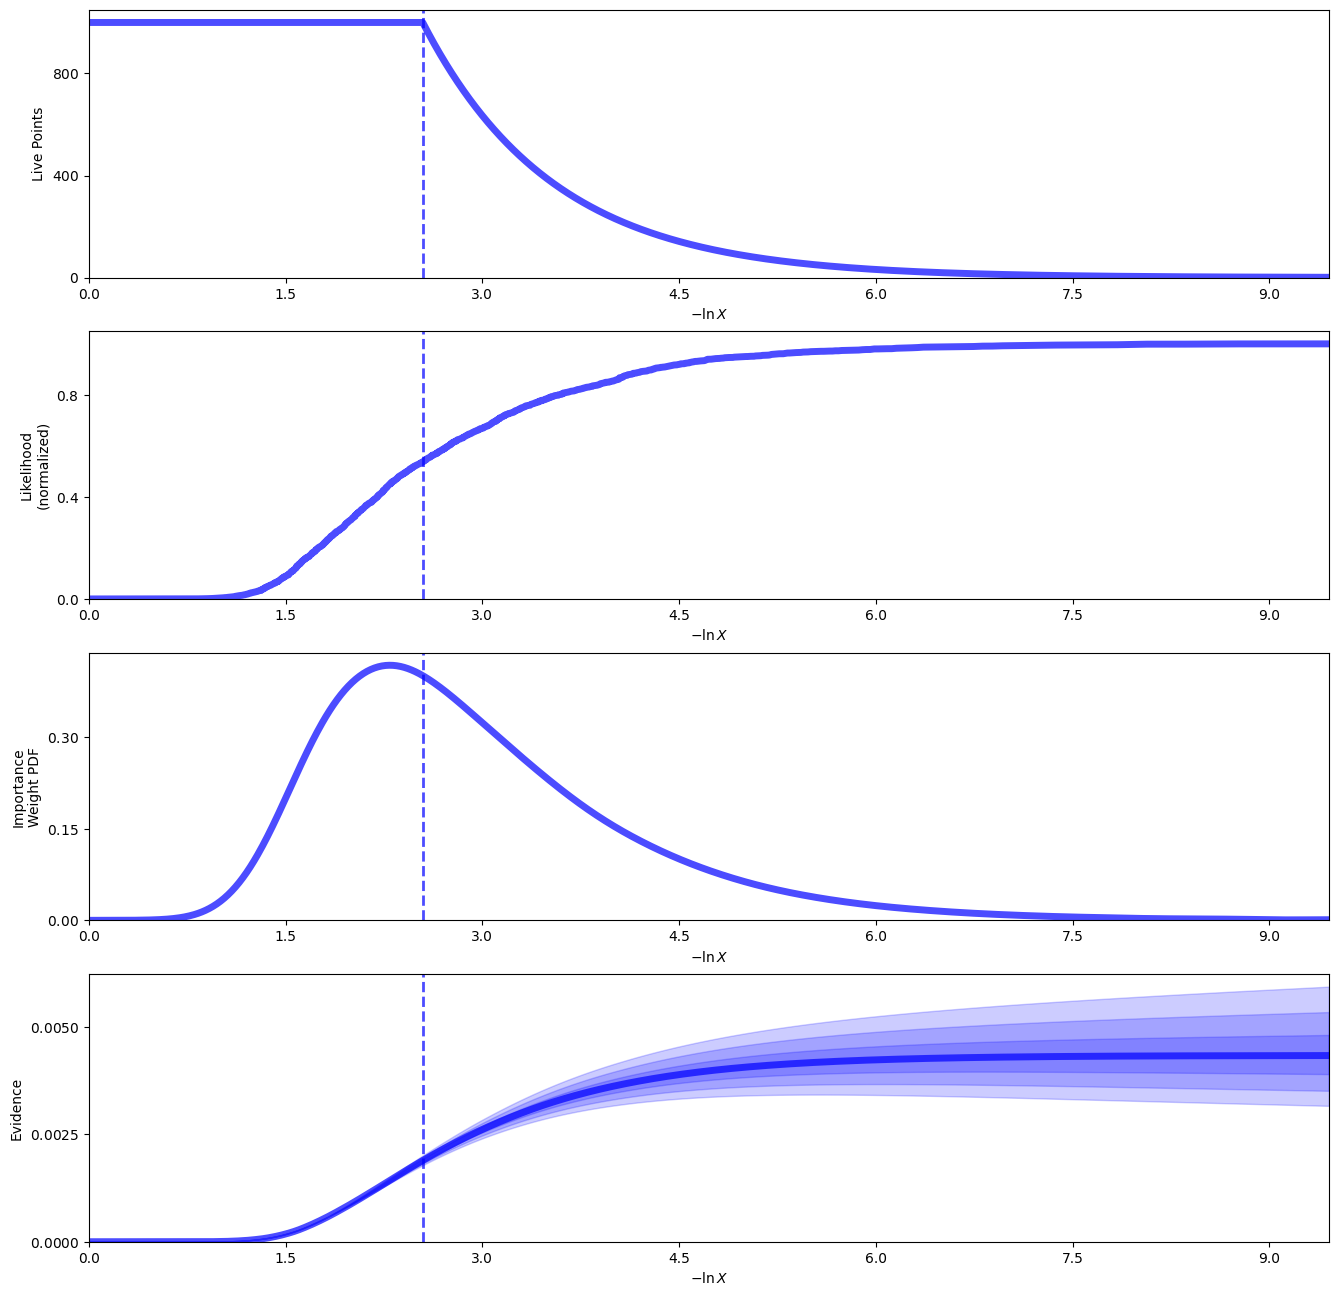

In [15]:
_ = dynesty.plotting.runplot(gen_result)

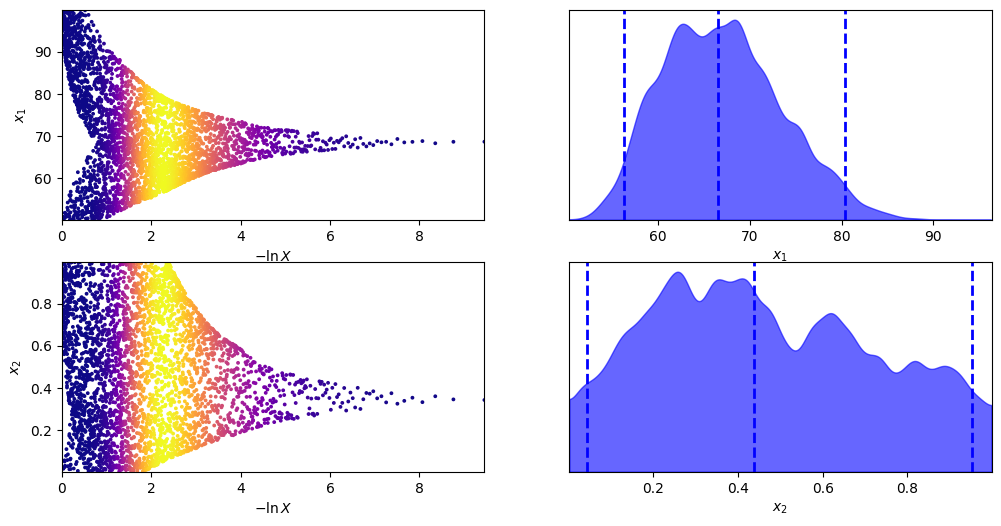

In [16]:
_ = dynesty.plotting.traceplot(gen_result)

#### Only matter model

In [17]:
def mat_model(z, par):
    tmp = LambdaCDM(H0=par[0], Om0=1.0, Ode0=0.0)
    return tmp.distmod(z).value

model = mat_model
n_par = 1

def prior_transf_mat(par):
    priors = np.zeros(n_par)
    priors[0] = 50.0 + 50.0 * par[0]
    return priors

sampler_mat = dynesty.NestedSampler(loglikelihood, prior_transf_mat, n_par, nlive=1000)
sampler_mat.run_nested()
mat_result = sampler_mat.results

2551it [00:05, 487.13it/s, +1000 | bound: 0 | nc: 1 | ncall: 13183 | eff(%): 29.147 | loglstar:   -inf < -3.888 <    inf | logz: -6.061 +/-    nan | dlogz:  0.001 >  1.009]


#### Diagnostic plots

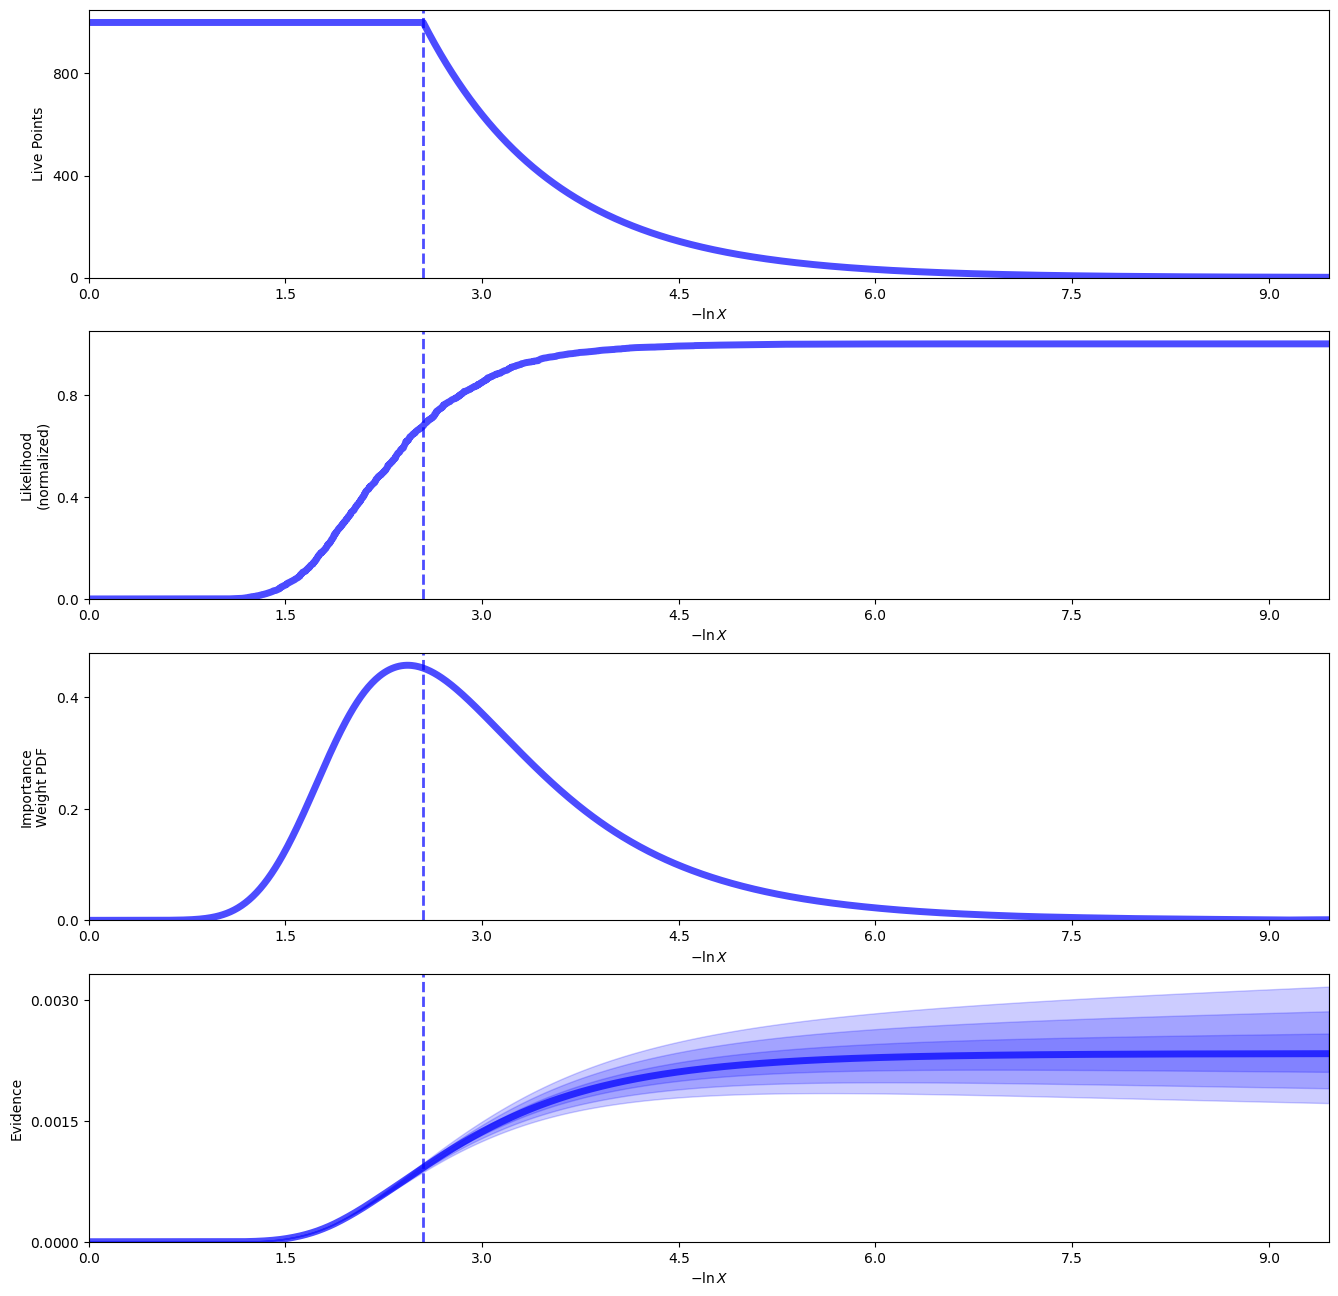

In [18]:
_ = dynesty.plotting.runplot(mat_result)

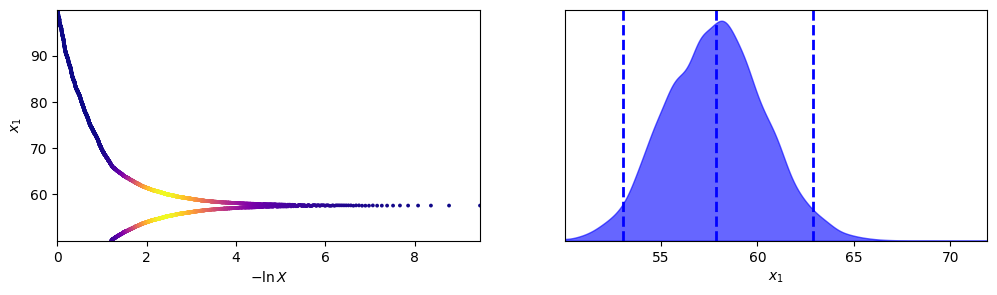

In [19]:
_ = dynesty.plotting.traceplot(mat_result)

#### Bayes factor and final results

In [20]:
print("Evidence of the general model: {} +- {}".format(gen_result.logz[-1], gen_result.logzerr[-1]))
print("Evidence of the only-matter model: {} +- {}".format(mat_result.logz[-1], mat_result.logzerr[-1]))
print("Bayes Factor: {} +- {}".format(gen_result.logz[-1] - mat_result.logz[-1], np.sqrt(gen_result.logzerr[-1] ** 2.0 + mat_result.logzerr[-1]** 2.0)))

Evidence of the general model: -5.44051173616519 +- 0.10496397094583532
Evidence of the only-matter model: -6.060962335564749 +- 0.10163494118300888
Bayes Factor: 0.6204505993995593 +- 0.14610645593536184


This analysis is inconclusive: these data are not enough to say that we need dark energy to explain them.
## Resampling the distributions

We now want to resample the distribution. We'll use both the Gaussain Process Regression and the cosmological model. We want to obtain 10000 new points. For the $z$ values, we make a Kernelm Density Estimation and upsample from it:

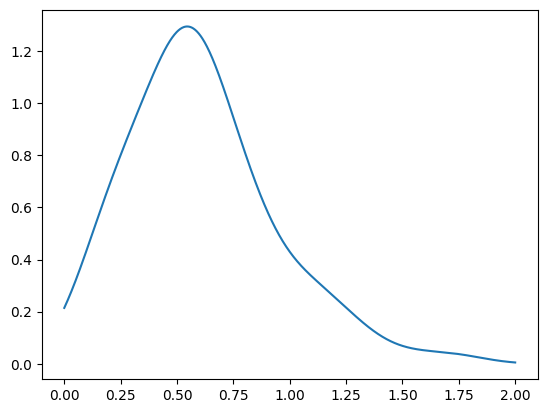

In [21]:
def kde_sklearn(data, bandwidth = 1.0):
    kde_skl = KernelDensity(kernel='gaussian', bandwidth = bandwidth)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf)

bw_range = np.linspace(0.01, 0.5, 20)
grid = GridSearchCV(KernelDensity(), {'bandwidth':bw_range}, cv = 5)
grid.fit(z_sample[:, np.newaxis])
b_opt = grid.best_params_['bandwidth']

xgrid = np.linspace(0, 2.0, 1000)
pdf = kde_sklearn(z_sample, b_opt)
plt.plot(xgrid, pdf)

### GPR resample
In this case, the $\mu$ values are extracted in this way: for every $z$ value, we predict the mean and the standard deviation using the regressor. The point is then extracted from a normal distribution with those parameters.

In [22]:
kde = KernelDensity(kernel='gaussian', bandwidth = b_opt)
kde.fit(z_sample[:, np.newaxis])
z_resample = np.array([])
for i in range(10000):
    extr = kde.sample(1)
    while extr <= 0.0:
        extr = kde.sample(1)
    z_resample = np.append(z_resample, extr)
z_resample = np.sort(z_resample)

In [23]:
mu_resample_gp = np.array([])
for i in range(10000):
    mean, sigma = reg_gp.predict([[z_resample[i]]], return_std = True)
    mu_resample_gp = np.append(mu_resample_gp, st.norm(mean, sigma).rvs(1))

Text(0.5, 1.0, 'Resample: Gaussian Process Regressor')

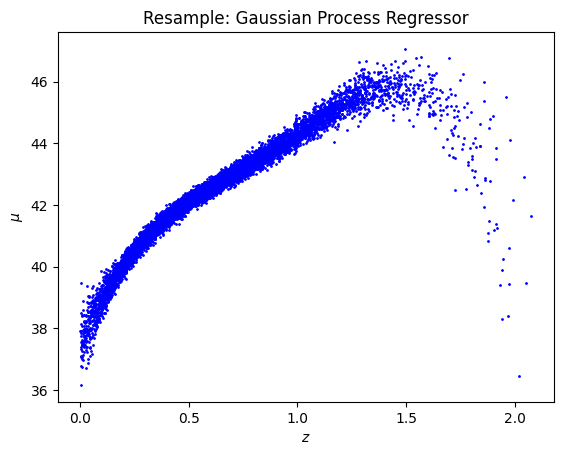

In [24]:
plt.plot(z_resample, mu_resample_gp, 'bo', markersize = 1)
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu$")
plt.title("Resample: Gaussian Process Regressor")

### Cosmological model
We now use the cosmological model, with $\Omega_m$ not fixed. In this case, for every $z$ value we extract a parameter configuration from the MCMC and predict the $\mu$ value using the model with those parameters.

In [25]:
mu_resample_lamda = np.array([])
for i in range(min(len(decorr_sample), 10000)):
    mu_resample_lamda = np.append(mu_resample_lamda, gen_model(z_resample[i], decorr_sample[i]))

Text(0.5, 1.0, 'Resample: the $\\Lambda$CDM model')

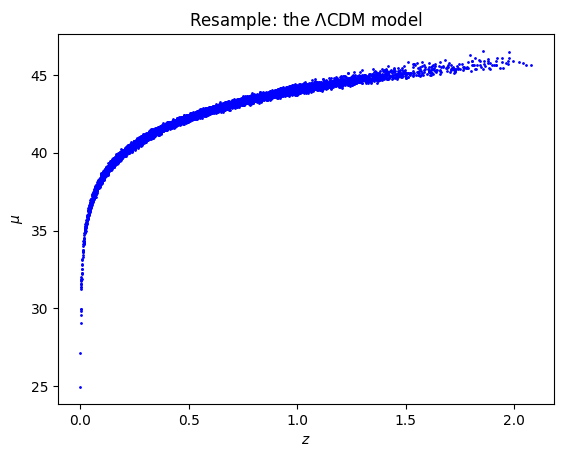

In [26]:
plt.plot(z_resample[:min(len(decorr_sample), 10000)], mu_resample_lamda, 'bo', markersize = 1)
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu$")
plt.title(r"Resample: the $\Lambda$CDM model")